In [2]:
import numpy as np
import pandas as pd
idx = pd.IndexSlice

import matplotlib.pyplot as plt

In [3]:
LOSS_COLS = ['num_atom_loss', 'composition_loss', 'coord_loss', 'type_loss', 'property_loss']

In [5]:
baseline_results_qm9 = pd.read_csv("/home/jake/Projects/mila/cdvae/assets/predictions/qm9_baseline.csv", index_col="dataset_id")
augmented_results_qm9 = pd.read_csv("/home/jake/Projects/mila/cdvae/assets/predictions/qm9_plain_pi.csv", index_col="dataset_id")

baseline_results_zinc = pd.read_csv("/home/jake/Projects/mila/cdvae/assets/predictions/zinc_baseline.csv", index_col="dataset_id")
augmented_results_zinc = pd.read_csv("/home/jake/Projects/mila/cdvae/assets/predictions/zinc_plain_pi.csv", index_col="dataset_id")

baseline_results_mp = pd.read_csv("/home/jake/Projects/mila/cdvae/assets/predictions/mp_baseline.csv", index_col="dataset_id")
augmented_results_mp = pd.read_csv("/home/jake/Projects/mila/cdvae/assets/predictions/mp_plain_pi.csv", index_col="dataset_id")

### Calculate Average Loss Component by Molecule Size

In [94]:
def combine_baseline_and_augmented_results(baseline_results: pd.DataFrame, augmented_results: pd.DataFrame):
    combined_results = baseline_results.join(augmented_results[LOSS_COLS], lsuffix="_baseline", rsuffix="_augmented")

    # bin observations by molecular size (atomic count)
    mol_size_edges = [0] + [i*10 for i in range(1,11)]
    mol_size_labels = [f"{(i-1)*10+1}-{i*10}" for i in range(1,11)]

    combined_results["size"] = pd.cut(combined_results["num_atoms"], bins=mol_size_edges, labels=mol_size_labels)
    combined_results = combined_results.set_index("size", append=True)

    # calculate improvement of augmented model over baseline model for each molecule's loss component
    for loss_col in LOSS_COLS:
        combined_results[f"{loss_col}_diff"] = combined_results[f"{loss_col}_baseline"] - combined_results[f"{loss_col}_augmented"]

    # transform from wide to long
    combined_results_long = combined_results.drop(columns="num_atoms").melt(ignore_index=False, var_name="loss_component")
    combined_results_long = combined_results_long.sort_index()

    # aggregate by bin
    combined_results_by_bin = combined_results_long.groupby(["loss_component","size"])["value"].agg([np.mean, np.std])

    # transform back to wide for easy plotting
    combined_results_by_mol_size_wide = combined_results_by_bin.unstack("loss_component")
    combined_results_by_mol_size_wide.columns = combined_results_by_mol_size_wide.columns.swaplevel()
    combined_results_by_bin = combined_results_by_mol_size_wide.sort_index(axis=1)

    # pad with full range of mol sizes for uniformity
    combined_results_by_bin = combined_results_by_bin.reindex(mol_size_labels)
    combined_results_by_bin = combined_results_by_bin.iloc[1:] # drop 0-10 bucket

    return combined_results_by_bin

In [95]:
combined_results_by_bin_qm9 = combine_baseline_and_augmented_results(baseline_results_qm9, augmented_results_qm9)
combined_results_by_bin_zinc = combine_baseline_and_augmented_results(baseline_results_zinc, augmented_results_zinc)
combined_results_by_bin_mp = combine_baseline_and_augmented_results(baseline_results_mp, augmented_results_mp)

In [101]:
combined_results_by_bin_qm9.iloc[:,:4].T

size                                11-20     21-30  31-40  41-50  51-60  \
loss_component                                                             
composition_loss_augmented mean  1.061381  0.849031    NaN    NaN    NaN   
                           std   0.131318  0.094686    NaN    NaN    NaN   
composition_loss_baseline  mean  1.068079  0.849015    NaN    NaN    NaN   
                           std   0.135844  0.094627    NaN    NaN    NaN   

size                             61-70  71-80  81-90  91-100  
loss_component                                                
composition_loss_augmented mean    NaN    NaN    NaN     NaN  
                           std     NaN    NaN    NaN     NaN  
composition_loss_baseline  mean    NaN    NaN    NaN     NaN  
                           std     NaN    NaN    NaN     NaN

### Generate Plots

### Plot 1: Average Improvement by Loss Component and Molecule Size

In [140]:
def bin_average_plot(combined_results_by_bin, loss_col: str, ax: plt.Axes = None, max_bin_val=3):
    bin_avg_improvement = \
        combined_results_by_bin[idx[f"{loss_col}_baseline","mean"]] - \
        combined_results_by_bin[idx[f"{loss_col}_augmented","mean"]]

    bin_avg_bottom = \
        combined_results_by_bin.loc[:,[f"{loss_col}_baseline",f"{loss_col}_augmented"]]\
            .loc[:,idx[:,"mean"]].min(axis=1)

    # color & hatch bars according to whether or not the augmented model
    # improved the baseline for the particular bin
    bar_colors = (bin_avg_improvement > 0).replace({True:"#99a3f7", False: "#f7e199"})
    edge_colors = (bin_avg_improvement > 0).replace({True:"#99a3f7", False: "#f7e199"})
    hatches = (bin_avg_improvement > 0).replace({True:"", False: "//"})

    labels = list(bin_avg_improvement.index)

    # return bin_avg_improvement, bottom, bin_avg_improvement.abs(), bar_colors
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    width = .8
    bars = ax.bar(
        x=range(len(labels)), bottom=bin_avg_bottom, height=bin_avg_improvement.abs(),
        color=bar_colors, edgecolor=edge_colors, hatch=hatches, width=width, tick_label=labels
    )
    ax.set_xticklabels(labels, rotation=40, ha='right')
    ax.set_xlim(-1+width/8, len(labels)+width/8)
    ax.set_ylim(0,)

    ax.fill_between(x=range(max_bin_val,len(labels)*2), y1=0,y2=1e9, color="#f2f2f2")

    return ax

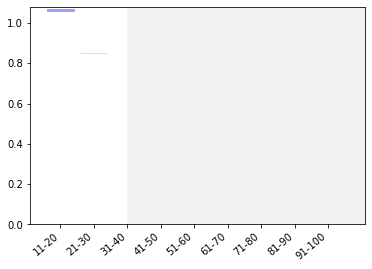

In [141]:
ax = bin_average_plot(combined_results_by_bin_qm9, LOSS_COLS[1], max_bin_val=2)

In [125]:
dataset_names = ["QM9","ZINC","MP"]
dataset_results = [combined_results_by_bin_qm9, combined_results_by_bin_zinc, combined_results_by_bin_mp]
datset_max_bin_vals = [2,7,11]

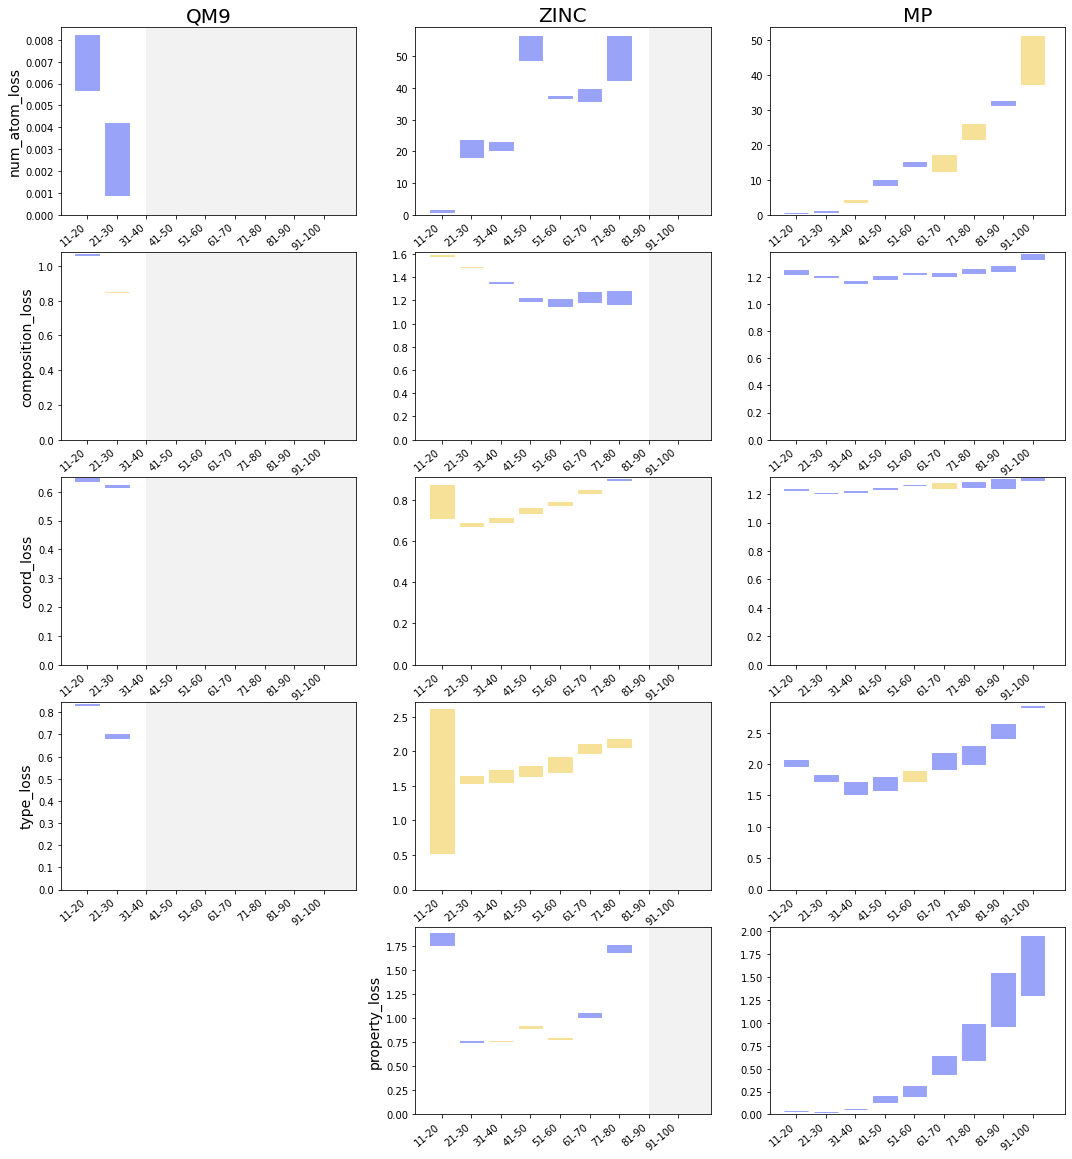

In [142]:
fig, axes = plt.subplots(len(LOSS_COLS), 3, figsize=(6*3, len(LOSS_COLS)*4))

for col, (dataset_name, dataset_result, max_bin_val) in enumerate(zip(dataset_names, dataset_results, datset_max_bin_vals)):
    for row, loss_col in enumerate(LOSS_COLS):
        if (dataset_name == "QM9") and (loss_col == "property_loss"):
            axes[row,col].axis("off") # QM9 was not trained on property prediction
        else:
            bin_average_plot(dataset_result, loss_col, ax=axes[row,col], max_bin_val=max_bin_val)
        
        if (col == 0) or ((col == 1) and (loss_col == "property_loss")):
            axes[row,col].set_ylabel(loss_col, fontsize=14)

        if row == 0:
            axes[row,col].set_title(dataset_name, fontsize=20)

Caption: Change in test set loss components attributable to augmentation with TDA. Each row corresponds to one component of the aggregate loss measure, and each column to a specific dataset. Each graph is stratified by molecule atom count, with gray background indicating strata above the maximum molecule size for each dataset. Blue bars indicate _improvement_; orange bars indicate worse performance.